In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter, minimum_filter, median_filter
from IPython.display import Image
from scipy.ndimage import zoom 
from scipy.ndimage.morphology import distance_transform_edt
from matplotlib.tri import Triangulation
import json

from nansat import Nansat, Domain, NSR, Figure

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking 
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.pmlib import prepare_first_guess, use_mcc, get_initial_rotation, rotate_and_match

# from s1denoise import Sentinel1Image

from osgeo import gdal
%matplotlib inline

In [2]:
NS_SRS = '+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +b=6356889.44891059 +units=m +no_defs'
NS_NSR = NSR(NS_SRS)

In [3]:
def get_fixed_n(n, img, time_coverage_start):
    # create new Nansat with one band only
    n2 = Nansat.from_domain(n, img)
    n2.set_metadata('time_coverage_start', time_coverage_start)

    # improve geolocation
    n2.reproject_gcps()
    n2.vrt.tps = True
    return n2

In [4]:
def get_n_radarsat2(filename):
#filename = '/Data/sat/downloads/Radarsat2/beaufort_sea/2013/RS2_OK37499_PK364900_DK322205_SCWA_20130224_023727_HH_HV_SGF'
    # open with nansat to get time
    n01 = Nansat(filename)
    time_coverage_start = n01.time_coverage_start

    # open with Nansat to find HH bandname
    filename_gdal = f'RADARSAT_2_CALIB:UNCALIB:{filename}/product.xml'
    n02 = Nansat(filename_gdal)

    try:
        band_id = n02.get_band_number({'POLARIMETRIC_INTERP': 'HH'})
    except:
        band_id = 1

    # replace zeros in low values (not near border)
    img = n02[band_id]
    img[100:-100, 100:-100] = np.clip(img[100:-100, 100:-100], 1, 255)

    # create new Nansat with one band only
    return get_fixed_n(n02, img, time_coverage_start)

In [5]:
def get_img_bbox(geo):
    lon, lat = np.array(json.loads(geo.ExportToJson())['coordinates'][0]).T
    dom = Domain(NS_SRS, '-te 0 0 1000 1000 -tr 1 -1')
    x, y = dom.transform_points(lon, lat, 1)
    return x.min(), y.min(), x.max(), y.max()

In [6]:
def get_domain_extent(n1, n2, resolution=5e3, buffer=50e3):
    geo1 = n1.get_border_geometry()
    geo2 = n2.get_border_geometry()
    inter = geo1.Intersection(geo2)
    interlon, interlat = np.array(json.loads(inter.ExportToJson())['coordinates'][0]).T
    dom = Domain(NS_SRS, '-te 0 0 1000 1000 -tr 1 -1')

    xbrd, ybrd = dom.transform_points(interlon, interlat, 1)
    xmin = np.floor(xbrd.min()/resolution)*resolution - buffer
    xmax = np.ceil(xbrd.max()/resolution)*resolution + buffer
    ymin = np.floor(ybrd.min()/resolution)*resolution - buffer
    ymax = np.ceil(ybrd.max()/resolution)*resolution + buffer
    bbox = xmin, xmax, ymin, ymax
    
    # plot extent should contain both images
    xmin1, ymin1, xmax1, ymax1 = get_img_bbox(geo1)
    xmin2, ymin2, xmax2, ymax2 = get_img_bbox(geo2)
    bbox_plot = [
        np.min([xmin1, xmin2]) - buffer,
        np.min([ymin1, ymin2]) - buffer,
        np.max([xmax1, xmax2]) + buffer,
        np.max([ymax1, ymax2]) + buffer,
    ]
    return bbox, bbox_plot

In [7]:
def fake_feature_tracking(n1, n2):
    # create fake feature tracking points
    n1rows, n1cols = n1.shape()
    n2rows, n2cols = n2.shape()

    stp = 500
    c1, r1 = [a.flatten() for a in np.meshgrid(np.arange(100, n1cols-100, stp), np.arange(100, n1rows-100, stp))]
    c1lon, r1lat = n1.transform_points(c1, r1)
    c2, r2 = n2.transform_points(c1lon, r1lat, DstToSrc=1)
    gpi = (c2 > 0) * (c2 < n2cols) * (r2 > 0) * (r2 < n2rows)
    print(f'Created {np.sum(gpi)} fake features')
    return c1[gpi], r1[gpi], c2[gpi], r2[gpi]

In [8]:
def fill_nan_gaps(array, distance=15):
    """ Fill gaps in input raster

    Parameters
    ----------
    array : 2D numpy.array
        Input ratser with nan values
    distance : int
        Minimum size of gap to fill

    Returns
    -------
    array : 2D numpy.array
        Ratser with nan gaps field with nearest neigbour values

    """
    array = np.array(array)
    dist, indi = distance_transform_edt(
        np.isnan(array),
        return_distances=True,
        return_indices=True)
    gpi = dist <= distance
    r,c = indi[:,gpi]
    array[gpi] = array[r,c]
    return array

In [9]:
def clean_velo_field(a, rpm, hpm, min_qual=2.5, fill_size=1, med_filt_size=3):
    """ Replace gaps with median filtered values """
    a2 = np.array(a)
    a2[(rpm * hpm) < min_qual] = np.nan
    a3 = fill_nan_gaps(a2, fill_size)
    a4 = median_filter(a3, med_filt_size)
    gpi = np.isnan(a2) * np.isfinite(a4) 
    a2[gpi] = a4[gpi]
    return a2

In [10]:
def get_deformation_elems(x, y, u, v, a):
    """ Compute deformation for given elements.
    Input X, Y, U, V are organized in three columns: for each node of M elements.
    To convert deformation rates from 1/s to %/day outputs should be multiplied by 8640000.
    Parameters
    ----------
    x : 3xM ndarray
        X-coordinates of nodes, m
    y : 3xM ndarray
        Y-coordinates of nodes, m
    u : 3xM ndarray
        U-component of nodes, m/s
    v : 3xM ndarray
        V-component of nodes, m/s
    a : Mx1 ndarray
        area of elements, m2
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    """
    # contour integrals of u and v [m/s * m ==> m2/s]
    ux = uy = vx = vy = 0
    for i0, i1 in zip([1, 2, 0], [0, 1, 2]):
        ux += (u[i0] + u[i1]) * (y[i0] - y[i1])
        uy -= (u[i0] + u[i1]) * (x[i0] - x[i1])
        vx += (v[i0] + v[i1]) * (y[i0] - y[i1])
        vy -= (v[i0] + v[i1]) * (x[i0] - x[i1])
    # divide integral by double area [m2/s / m2 ==> 1/day]
    ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]

    # deformation components
    e1 = ux + vy
    e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
    e3 = np.hypot(e1, e2)

    return e1, e2, e3

In [11]:
def get_deformation_nodes(x, y, u, v):
    """ Compute deformation for given nodes.
    Input X, Y, U, V are given for individual N nodes. Nodes coordinates are triangulated and
    area, perimeter and deformation is computed for M elements.
    Parameters
    ----------
    x : Nx1 ndarray
        X-coordinates of nodes, m
    y : Nx1 ndarray
        Y-coordinates of nodes, m
    u : Nx1 ndarray
        U-component of nodes, m/s
    v : Nx1 ndarray
        V-component of nodes, m/s
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    a : Mx1 array
        Area, m2
    p : Mx1 array
        Perimeter, m
    t : 3xM array
        Triangulation (indices of input nodes for each element)
    """
    tri = Triangulation(x, y)

    # coordinates and speeds of corners of each element
    xt, yt, ut, vt = [i[tri.triangles].T for i in (x, y, u, v)]

    # side lengths (X,Y,tot)
    tri_x = np.diff(np.vstack([xt, xt[0]]), axis=0)
    tri_y = np.diff(np.vstack([yt, yt[0]]), axis=0)
    tri_s = np.hypot(tri_x, tri_y)
    # perimeter
    tri_p = np.sum(tri_s, axis=0)
    s = tri_p/2
    # area
    tri_a = np.sqrt(s * (s - tri_s[0]) * (s - tri_s[1]) * (s - tri_s[2]))

    # deformation components
    e1, e2, e3 = get_deformation_elems(xt, yt, ut, vt, tri_a)

    return e1, e2, e3, tri_a, tri_p, tri.triangles

In [12]:
# image in stereographic projection
def get_projected_hh(n, dom, **kwargs):
    n.reproject(dom, addmask=True, **kwargs)
    hh = np.ma.array(n[1], dtype=float, mask=1-n[2])
    n.undo()
    return hh

In [13]:
# watermask in specific projection
def get_projected_watermask(n, dom, **kwargs):
    n.reproject(dom, **kwargs)
    mask = n.watermask()[1]
    n.undo()
    return mask

In [14]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
# data_dir = '/Data/sat/downloads/Radarsat2/beaufort_sea/2013'
data_dir = os.getenv('RS2_dir')
f1 = os.path.join(data_dir, 'RS2_OK37499_PK364900_DK322205_SCWA_20130224_023727_HH_HV_SGF')
f2 = os.path.join(data_dir, 'RS2_OK37500_PK364951_DK322250_SCWA_20130225_020811_HH_HV_SGF')

In [15]:
n1 = get_n_radarsat2(f1) #2nd image is for plotting
n2 = get_n_radarsat2(f2)

In [16]:
# define regular grid with lon/lat coordinates
# EPSG_CODE = 3413
RES = 5000.
(xmin, xmax, ymin, ymax), bbox_plot = get_domain_extent(
        n1, n2, resolution=RES, buffer=25e3)
print(xmin, xmax, ymin, ymax)

xgrd, ygrd = np.meshgrid(np.arange(xmin, xmax, RES), np.arange(ymax, ymin, -RES))

# destination domain
dst_dom = Domain(NS_SRS,
        '-te %d %d %d %d -tr %d %d' %
        (xmin, ymin, xmax, ymax, RES, RES))
lon1pm, lat1pm = dst_dom.get_geolocation_grids()
print(lon1pm.shape)
# srs=NSR(EPSG_CODE).wkt

-1815000.0 -1260000.0 -85000.0 370000.0
(91, 111)


In [17]:
wmask = get_projected_watermask(n1, dst_dom)

In [18]:
# create fake features
c1, r1, c2, r2 = fake_feature_tracking(n1, n2)

Created 250 fake features


In [19]:
# Run Pattern Matching with excessive parameters
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(
    lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, 
    srs=NS_SRS, img_size=71, 
    min_border=500, max_border=500,
    angles=[-10, -5, 0, 5, 10],
    threads=10)

80% 09972.9 00313.9 06528.0 00649.0 +00.0 0.36 17.24
 Pattern matching - OK! (614 sec)


In [20]:
# convert displacement to velocity
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u, v = upm/delta_t, vpm/delta_t

# clean velocity field
u2 = clean_velo_field(u, rpm, hpm, 2)
v2 = clean_velo_field(v, rpm, hpm, 2)
gpi = np.isfinite(u2*v2)
print(f'Found {np.sum(gpi)} good vectors')


# deformation rates
e1, e2, e3, a, p, t = get_deformation_nodes(xgrd[gpi], ygrd[gpi], u2[gpi], v2[gpi])

# convert deformation rates to %/day
e1 *= 8640000
e2 *= 8640000
e3 *= 8640000

Found 4214 good vectors


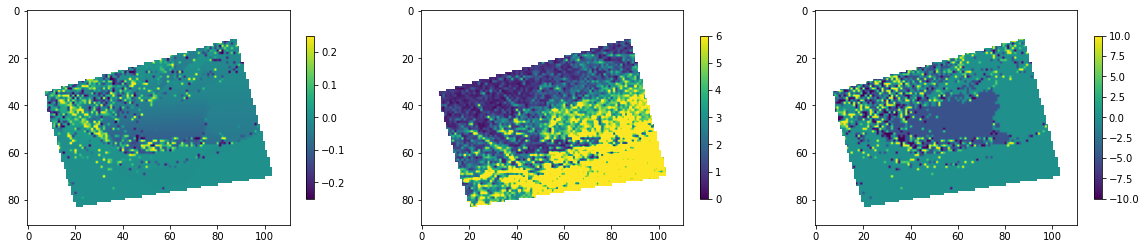

In [21]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
im0 = ax[0].imshow(u, vmin=-.25, vmax=.25)
fig.colorbar(im0, ax=ax[0], shrink=0.3)
im1 = ax[1].imshow(rpm * hpm, clim=[0, 6])
fig.colorbar(im1, ax=ax[1], shrink=0.3)
im2 = ax[2].imshow(apm)
fig.colorbar(im2, ax=ax[2], shrink=0.3)

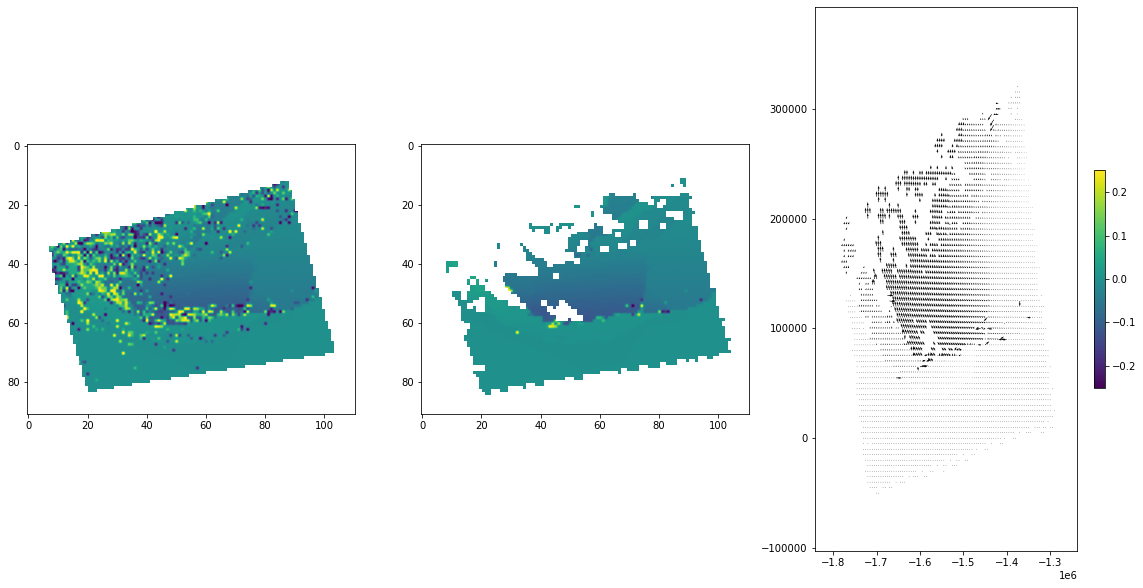

In [22]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
im0 = ax[0].imshow(u, vmin=-.25, vmax=.25)
im1 = ax[1].imshow(u2, vmin=-.25, vmax=.25)
fig.colorbar(im1, shrink=.4)
ax[2].quiver(xgrd, ygrd, u2, v2)

Text(0.5, 1.0, 'Shear, %/day')

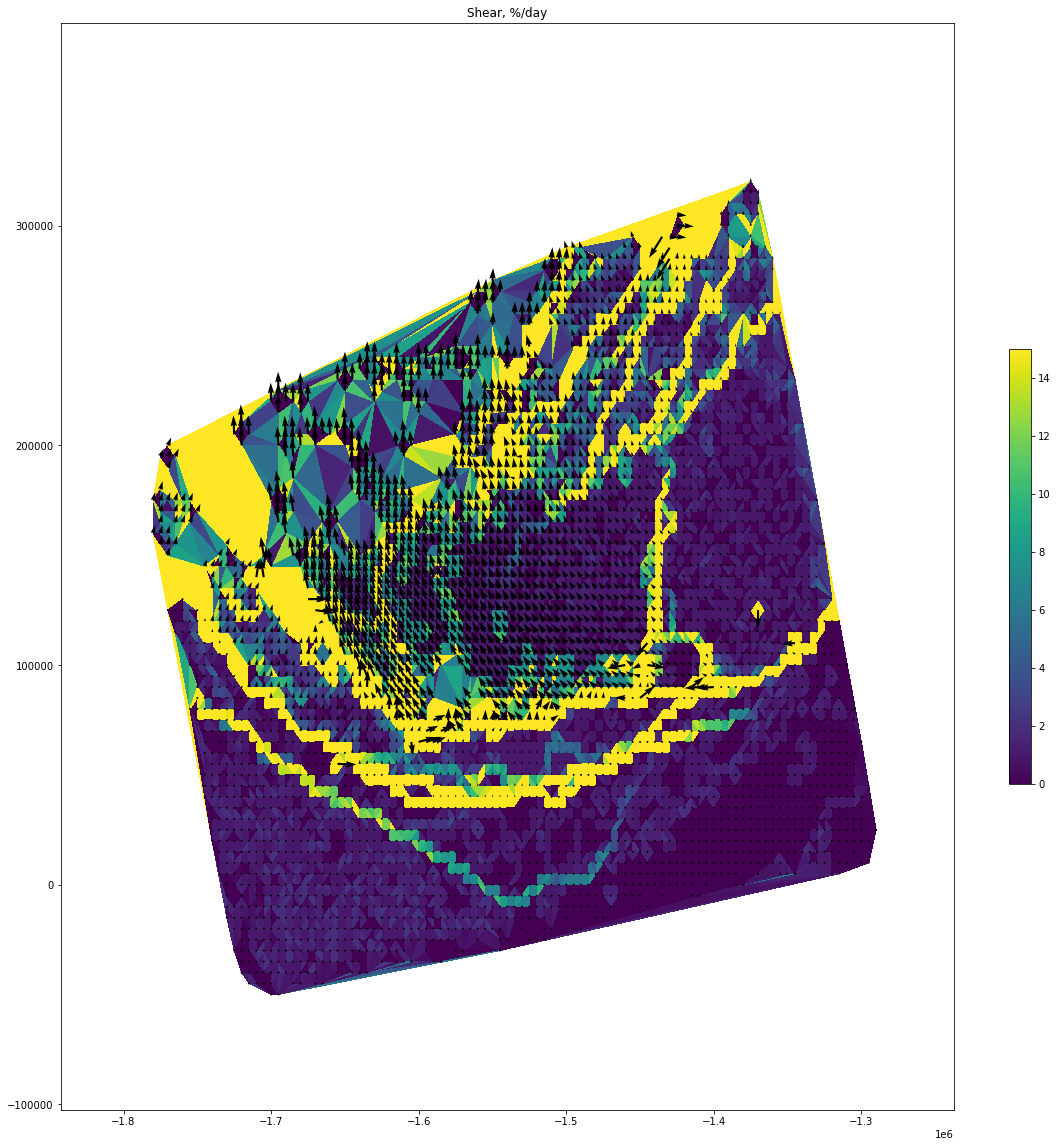

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
im = ax.tripcolor(xgrd[gpi], ygrd[gpi], t, e2, mask=np.isnan(e2), vmax=15)
ax.quiver(xgrd, ygrd, u2, v2)
fig.colorbar(im, shrink=0.4)
ax.set_title('Shear, %/day')

## Plot SAR images at higher resolution

In [24]:
res = 1e3
xmin, ymin, xmax, ymax = bbox_plot
ext = '-te %f %f %f %f -tr %f %f' % (xmin, ymin, xmax, ymax, res, res)
d = Domain(NS_SRS, ext)
hh1 = get_projected_hh(n1, d, resample_alg=0)
hh2 = get_projected_hh(n2, d, resample_alg=0)

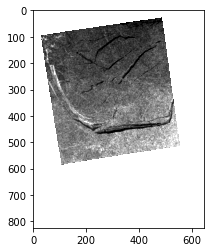

In [25]:
(vmin,), (vmax,) = Figure(n1[1]).clim_from_histogram(ratio=.9)
hh = np.ma.array(median_filter(hh1.data, 3), mask=hh1.mask)
plt.imshow(hh, cmap='gray', vmin=vmin, vmax=vmax)

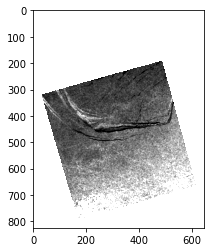

In [26]:
hh = np.ma.array(median_filter(hh2.data, 3), mask=hh2.mask)
plt.imshow(hh, cmap='gray', vmin=vmin, vmax=vmax)

In [27]:
# get coords of plot grid
lon_plot, lat_plot = d.get_geolocation_grids()